# Machine Learning - Practical 1

Names: {YOUR NAMES}

This notebook provides you with the assignments and the overall code structure you need to complete the assignment. There are also questions that you need to answer in text form. Please use full sentences and reasonably correct spelling/grammar.

Regarding submission & grading:

- Work in groups of three and hand in your solution as a group.

- Solutions need to be uploaded to StudIP until the submission date indicated in the course plan. Please upload a copy of this notebook and a PDF version of it after you ran it.

- Solutions need to be presented to tutors in tutorial. Presentation dates are listed in the course plan. Every group member needs to be able to explain everything.

- You have to solve N-1 practicals to get admission to the exam.

- For plots you create yourself, all axes must be labeled. 

- Do not change the function interfaces.

In [97]:
%matplotlib inline

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy.io import loadmat
from scipy import stats
import copy
import pylab
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score

## The  dataset

The dataset consists of over 20.000 materials and lists their physical features. From these features, we want to learn how to predict the critical temperature, i.e. the temperature we need to cool the material to so it becomes superconductive. First load and familiarize yourself with the data set a bit.

In [98]:
data = pd.read_csv('data/superconduct_train.csv')
print(data.shape)

(21263, 82)


In [99]:
data.head()

number_of_elements  mean_atomic_mass  wtd_mean_atomic_mass  \
0                   4         88.944468             57.862692   
1                   5         92.729214             58.518416   
2                   4         88.944468             57.885242   
3                   4         88.944468             57.873967   
4                   4         88.944468             57.840143   

   gmean_atomic_mass  wtd_gmean_atomic_mass  entropy_atomic_mass  \
0          66.361592              36.116612             1.181795   
1          73.132787              36.396602             1.449309   
2          66.361592              36.122509             1.181795   
3          66.361592              36.119560             1.181795   
4          66.361592              36.110716             1.181795   

   wtd_entropy_atomic_mass  range_atomic_mass  wtd_range_atomic_mass  \
0                 1.062396          122.90607              31.794921   
1                 1.057755          122.90607              36.161939   
2                 0.975980          122.90607              35.741099   
3                 1.022291          122.90607              33.768010   
4                 1.129224          122.90607              27.848743   

   std_atomic_mass  ...  wtd_mean_Valence  gmean_Valence  wtd_gmean_Valence  \
0        51.968828  ...          2.257143       2.213364           2.219783   
1        47.094633  ...          2.257143       1.888175           2.210679   
2        51.968828  ...          2.271429       2.213364           2.232679   
3        51.968828  ...          2.264286       2.213364           2.226222   
4        51.968828  ...          2.242857       2.213364           2.206963   

   entropy_Valence  wtd_entropy_Valence  range_Valence  wtd_range_Valence  \
0         1.368922             1.066221              1           1.085714   
1         1.557113             1.047221              2           1.128571   
2         1.368922             1.029175              1           1.114286   
3         1.368922             1.048834              1           1.100000   
4         1.368922             1.096052              1           1.057143   

   std_Valence  wtd_std_Valence  critical_temp  
0     0.433013         0.437059           29.0  
1     0.632456         0.468606           26.0  
2     0.433013         0.444697           19.0  
3     0.433013         0.440952           22.0  
4     0.433013         0.428809           23.0  

[5 rows x 82 columns]

Because the dataset is rather large, we prepare a small subset of the data as training set, and another subset as test set. To make the computations reproducible, we set the random seed.

In [100]:
target_clm = 'critical_temp'  # the critical temperature is our target variable
n_trainset = 200  # size of the training set
n_testset = 500  # size of the test set

In [101]:
# set random seed to make sure every test set is the same
np.random.seed(seed=1)

idx = np.arange(data.shape[0])
idx_shuffled = np.random.permutation(idx)  # shuffle indices to split into training and test set

test_idx = idx_shuffled[:n_testset]
train_idx = idx_shuffled[n_testset:n_testset+n_trainset]
train_full_idx = idx_shuffled[n_testset:]

X_test = data.loc[test_idx, data.columns != target_clm].values
y_test = data.loc[test_idx, data.columns == target_clm].values
print('Test set shapes (X and y)', X_test.shape, y_test.shape)

X_train = data.loc[train_idx, data.columns != target_clm].values
y_train = data.loc[train_idx, data.columns == target_clm].values
print('Small training set shapes (X and y):', X_train.shape, y_train.shape)

X_train_full = data.loc[train_full_idx, data.columns != target_clm].values
y_train_full = data.loc[train_full_idx, data.columns == target_clm].values
print('Full training set shapes (X and y):', X_train_full.shape, y_train_full.shape)

Test set shapes (X and y) (500, 81) (500, 1)
Small training set shapes (X and y): (200, 81) (200, 1)
Full training set shapes (X and y): (20763, 81) (20763, 1)


## Task 1: Plot the dataset

To explore the dataset, use `X_train_full` and `y_train_full` for two descriptive plots:

* **Histogram** of the target variable. Use `plt.hist`.

* **Scatterplots** relating the target variable to one of the feature values. For this you will need 81 scatterplots. Arrange them in one big figure with 9x9 subplots. Use `plt.scatter`. You may need to adjust the marker size and the alpha blending value. 

Furthermore, we need to normalize the data, such that each feature has a mean of zero mean and a variance of one. Implement a function `normalize` which normalizes the data. Print the means and standard variation of the first five features before and after. For simplicity we will normalize train and test set independently. It is better practice to normalize the test set with mean and variance of the test set. Maybe you can think of situations / reasons where this makes a difference.

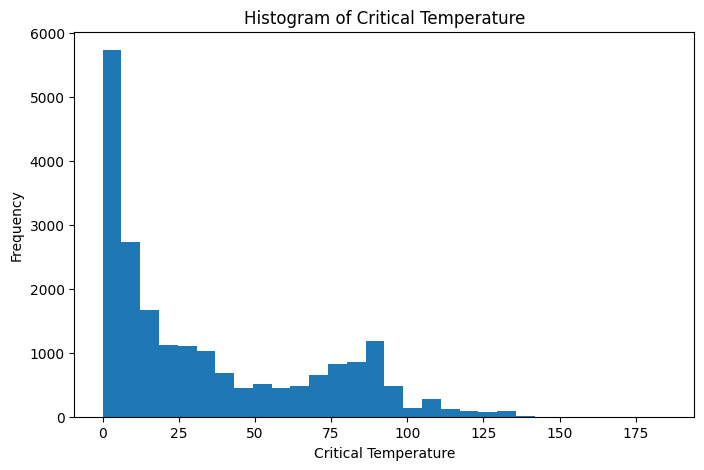

In [102]:
# Histogram of the target variable
plt.figure(figsize=(8, 5))
plt.hist(y_train_full, bins=30)
plt.xlabel('Critical Temperature')
plt.ylabel('Frequency')
plt.title('Histogram of Critical Temperature')
plt.show()






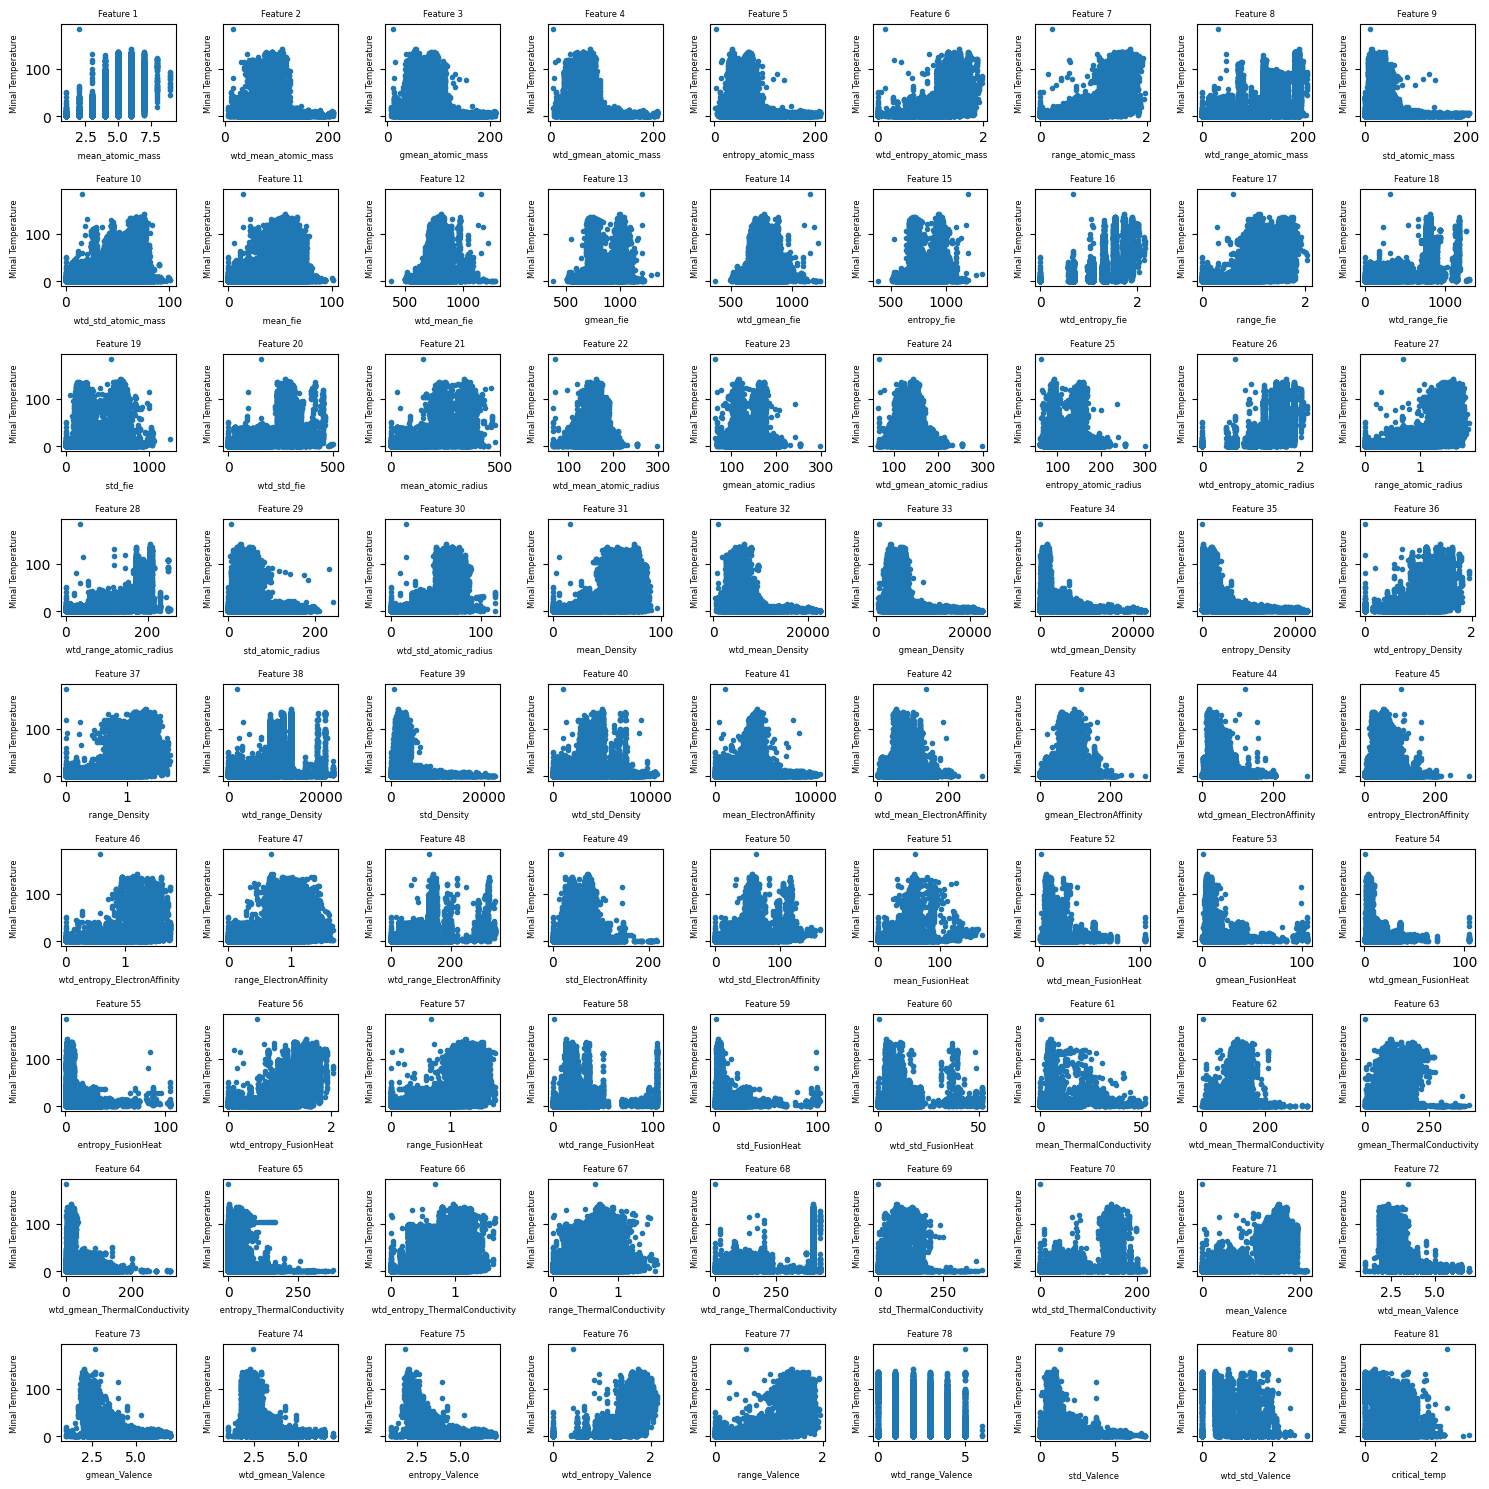

In [103]:
# Scatter plots of the target variable vs. features
titel = list(data)
fig, axes = plt.subplots(9, 9,sharey=True, figsize=(15, 15))
plt.subplots_adjust(hspace=1)
for i, ax in enumerate(axes.flatten()):
    if i < 81:
        ax.scatter(X_train_full[:, i], y_train_full, marker=".")
        ax.set_title(f'Feature {i+1}',fontsize="6")
        ax.set_xlabel(f' {titel[i+1]}',fontsize="6")
        ax.set_ylabel('Minal Temperature',fontsize="6")
    else:
        ax.axis('off')
plt.tight_layout()
plt.show()

In [104]:
# Normalize
def normalize(data):
    mean = np.mean(data, axis=0)
    std = np.std(data, axis=0)
    return (data - mean) / std


In [105]:
# Normalize the datasets
X_train_normalized = normalize(X_train)
X_test_normalized = normalize(X_test)

# Print the means and standard deviations of the first five features before and after normalization
print("Before normalization:")
print("Means:", np.mean(X_train[:, :5], axis=0))
print("Standard deviations:", np.std(X_train[:, :5], axis=0))

print("After normalization:")
print("Means:", np.mean(X_train_normalized[:, :5], axis=0))
print("Standard deviations:", np.std(X_train_normalized[:, :5], axis=0))

Before normalization:
Means: [ 4.185      87.7163336  73.21230301 71.15119649 58.43925605]
Standard deviations: [ 1.51022349 29.24216734 31.44389947 30.72585987 34.87710465]
After normalization:
Means: [ 2.93098879e-16 -2.30926389e-16 -4.79616347e-16 -3.86357613e-16
  8.43769499e-17]
Standard deviations: [1. 1. 1. 1. 1.]


Which material properties may be useful for predicting superconductivity? What other observations can you make?

 YOUR ANSWER HERE

## Task 2:  Implement your own OLS estimator

We want to use linear regression to predict the critical temperature. Implement the ordinary least squares estimator without regularization 'by hand':

$w = (X^TX)^{-1}X^Ty$

To make life a bit easier, we provide a function that can be used to plot regression results. In addition it computes the mean squared error and the squared correlation between the true and predicted values. 

In [106]:
def plot_regression_results(y_test, y_pred, weights):
    '''Produces three plots to analyze the results of linear regression:
        -True vs predicted
        -Raw residual histogram
        -Weight histogram

    Inputs:
        y_test: (n_observations,) numpy array with true values
        y_pred: (n_observations,) numpy array with predicted values
        weights: (n_weights) numpy array with regression weights'''

    print('MSE: ', mean_squared_error(y_test, y_pred))
    print('r^2: ', r2_score(y_test, y_pred))

    fig, ax = plt.subplots(1, 3, figsize=(9, 3))
    # predicted vs true
    ax[0].scatter(y_test, y_pred)
    ax[0].set_title('True vs. Predicted')
    ax[0].set_xlabel('True %s' % (target_clm))
    ax[0].set_ylabel('Predicted %s' % (target_clm))

    # residuals
    error = np.squeeze(np.array(y_test)) - np.squeeze(np.array(y_pred))
    ax[1].hist(np.array(error), bins=30)
    ax[1].set_title('Raw residuals')
    ax[1].set_xlabel('(true-predicted)')

    # weight histogram
    ax[2].hist(weights, bins=30)
    ax[2].set_title('weight histogram')

    plt.tight_layout()

As an example, we here show you how to use this function with random data. 

MSE:  2640.432578444892
r^2:  -1.108062856115481


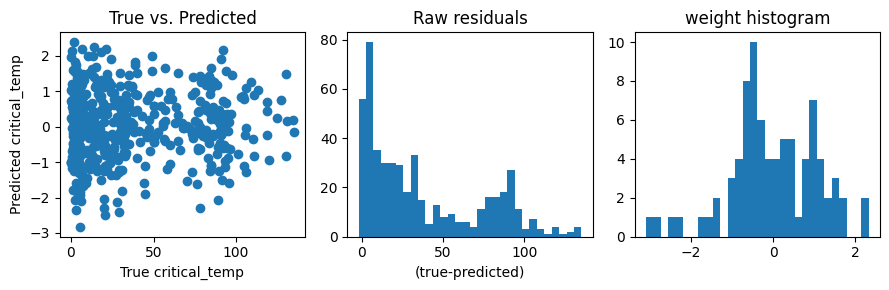

In [107]:
# weights is a vector of length 82: the first value is the intercept (beta0), then 81 coefficients
weights = np.random.randn(82)

# Model predictions on the test set
y_pred_test = np.random.randn(y_test.size)

plot_regression_results(y_test, y_pred_test, weights)

Implement OLS linear regression yourself. Use `X_train` and `y_train` for estimating the weights and compute the MSE and $r^2$ from `X_test`. When you call our plotting function with the regession result, you should get mean squared error of 707.8.

In [108]:
def OLS_regression(X_test, X_train, y_train):
    '''Computes OLS weights for linear regression without regularization on the training set and
       returns weights and testset predictions.

       Inputs:
         X_test: (n_observations, 81), numpy array with predictor values of the test set
         X_train: (n_observations, 81), numpy array with predictor values of the training set
         y_train: (n_observations,) numpy array with true target values for the training set

       Outputs:
         weights: The weight vector for the regerssion model including the offset
         y_pred: The predictions on the TEST set

       Note:
         Both the training and the test set need to be appended manually by a columns of 1s to add
         an offset term to the linear regression model.
    '''

    # ---------------- INSERT CODE ----------------------

    # Append a column of 1s to the training and test sets to add an offset term
    X_train_offset = np.hstack((np.ones((X_train.shape[0], 1)), X_train))
    X_test_offset = np.hstack((np.ones((X_test.shape[0], 1)), X_test))

    # Compute the OLS weights
    weights = np.linalg.inv(X_train_offset.T @ X_train_offset) @ X_train_offset.T @ y_train

    # Compute the predictions on the test set
    y_pred = X_test_offset @ weights

    # ---------------- END CODE -------------------------

    return weights, y_pred

MSE:  707.8008844986445
r^2:  0.43490745936180797


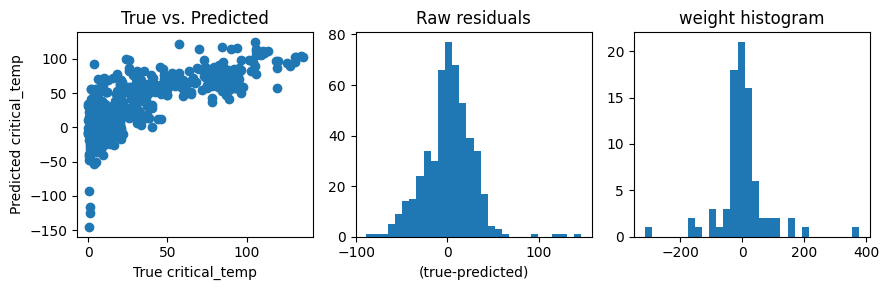

In [109]:
# Plots of the results

# Compute the weights and predictions using the OLS_regression function
weights, y_pred = OLS_regression(X_test_normalized, X_train_normalized, y_train)

# Plot the results using the plot_regression_results function
plot_regression_results(y_test, y_pred, weights)

What do you observe? Is the linear regression model good?

## Task 3: Compare your implementation to sklearn

Now, familarize yourself with the sklearn library. In the section on linear models:

https://scikit-learn.org/stable/modules/classes.html#module-sklearn.linear_model

you will find `sklearn.linear_model.LinearRegression`, the `sklearn` implementation of the OLS estimator. Use this sklearn class to implement OLS linear regression. Again obtain estimates of the weights on `X_train` and `y_train` and compute the MSE and $r^2$ on `X_test`.


In [110]:
from sklearn.linear_model import LinearRegression

In [111]:
def sklearn_regression(X_test, X_train, y_train):
    '''Computes OLS weights for linear regression without regularization using the sklearn library on the training set and
       returns weights and testset predictions.

       Inputs:
         X_test: (n_observations, 81), numpy array with predictor values of the test set
         X_train: (n_observations, 81), numpy array with predictor values of the training set
         y_train: (n_observations,) numpy array with true target values for the training set

       Outputs:
         weights: The weight vector for the regerssion model including the offset
         y_pred: The predictions on the TEST set

       Note:
         The sklearn library automatically takes care of adding a column for the offset.
    '''

    # ---------------- INSERT CODE ----------------------
        # Create a linear regression model using sklearn
    model = linear_model.LinearRegression()

    # Fit the model to the training data
    model.fit(X_train, y_train)

    # Obtain the predictions on the test set
    y_pred = model.predict(X_test)

    # Get the weights (including the offset term)
    weights = model.coef_


    



    # ---------------- END CODE -------------------------

    return weights, y_pred

MSE:  707.8008845060014
r^2:  0.43490745935593444


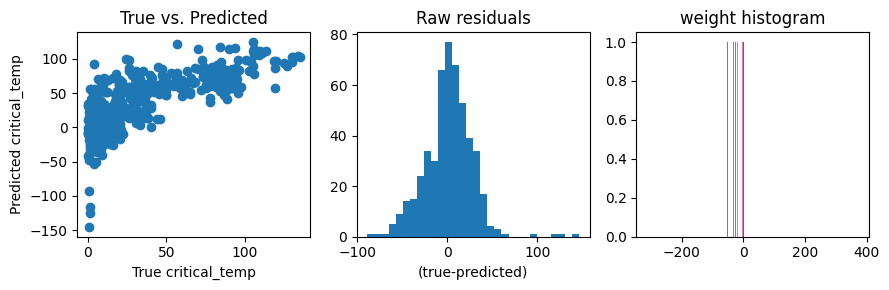

In [112]:
weights, y_pred = sklearn_regression(X_test_normalized, X_train_normalized, y_train)
plot_regression_results(y_test, y_pred, weights)

If you implemented everything correctly, the MSE is again 707.8.

Fit the model using the larger training set, `X_train_full` and `y_train_full`, and again evaluate on `X_test`.

MSE:  329.86070104107165
r^2:  0.736646526317881


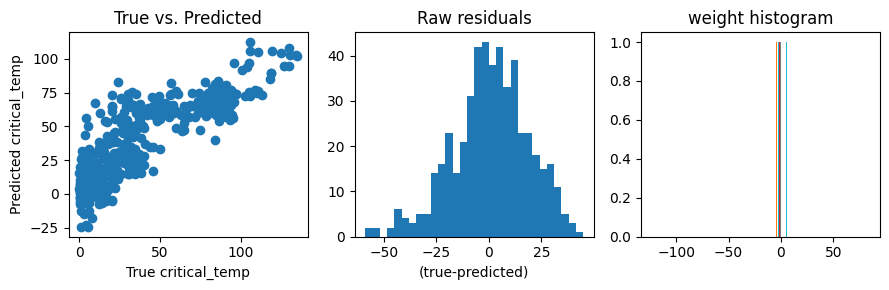

In [113]:
weights, y_pred = sklearn_regression(X_test, X_train_full, y_train_full)
plot_regression_results(y_test, y_pred, weights)

 How does test set performance change? What else changes?

YOU ANSWER HERE

## Task 4: Regularization with ridge regression

We will now explore how a penalty term on the weights can improve the prediction quality for finite data sets. Implement the analytical solution of ridge regression 

$w = (X^TX + \alpha I_D)^{-1}X^Ty$


as a function that can take different values of $\alpha$, the regularization strength, as an input. In the lecture, this parameter was called $\lambda$, but this is a reserved keyword in Python.

In [30]:
def ridge_regression(X_test, X_train, y_train, alpha):
    '''Computes OLS weights for regularized linear regression with regularization strength alpha
       on the training set and returns weights and testset predictions.

       Inputs:
         X_test: (n_observations, 81), numpy array with predictor values of the test set
         X_train: (n_observations, 81), numpy array with predictor values of the training set
         y_train: (n_observations,) numpy array with true target values for the training set
         alpha: scalar, regularization strength

       Outputs:
         weights: The weight vector for the regression model including the offset
         y_pred: The predictions on the TEST set

       Note:
         Both the training and the test set need to be appended manually by a columns of 1s to add
         an offset term to the linear regression model.
    '''

    # ---------------- INSERT CODE ----------------------
    # Add a column of 1s for the offset term
    X_train_offset = np.hstack((np.ones((X_train.shape[0], 1)), X_train))
    X_test_offset = np.hstack((np.ones((X_test.shape[0], 1)), X_test))

    #  ridge regression 
    weights = np.linalg.inv(X_train_offset.T.dot(X_train_offset) + alpha * np.identity(X_train_offset.shape[1])).dot(X_train_offset.T).dot(y_train)

    # predict the target values 
    y_pred = X_test_offset.dot(weights)



    # ---------------- END CODE -------------------------

    return weights, y_pred

Run the ridge regression on `X_train` with an alpha value of 10 and plot the obtained weights.

MSE:  429.73785002168387
r^2:  0.6569068239450431


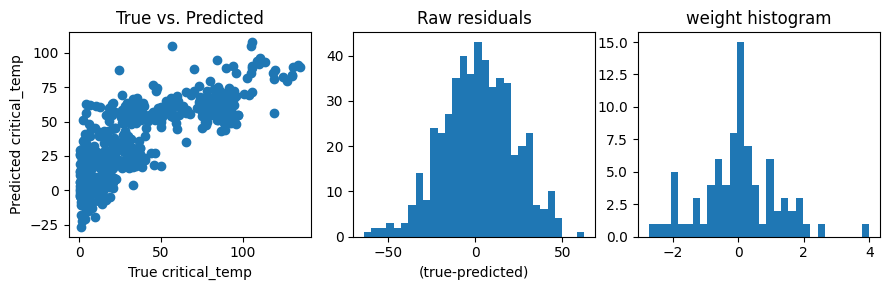

In [31]:
# Run ridge regression with alpha=10
alpha = 10
weights, y_pred = ridge_regression(X_test, X_train, y_train, alpha)


# Plot regression results
plot_regression_results(y_test, y_pred, weights)

Now test a range of log-spaced $\alpha$s (~10-20), which cover several orders of magnitude, e.g. from 10^-7 to 10^7. 

* For each $\alpha$, you will get one model with one set of weights. 
* For each model, compute the error on the test set. 

Store both the errors and weights of all models for later use. You can use the function `mean_squared_error` from sklearn (imported above) to compute the MSE.


In [114]:
alphas = np.logspace(-7, 7, 100)

# ---------------- INSERT CODE ----------------------
mse_list = []
weights_list = []

for alpha in alphas:
    weights, y_pred = ridge_regression(X_test, X_train, y_train, alpha)
    mse = mean_squared_error(y_test, y_pred)
    mse_list.append(mse)
    weights_list.append(weights)

mse_list = np.array(mse_list)
weights_list = np.array(weights_list)


# ---------------- END CODE -------------------------

Make a single plot that shows for each coefficient how it changes with $\alpha$, i.e. one line per coefficient. Also think about which scale is appropriate for your $\alpha$-axis. You can set this using `plt.xscale(...)`.

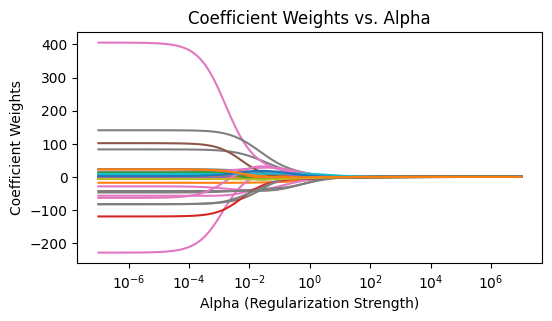

In [118]:
# Plot of coefficients vs. alphas
plt.figure(figsize=(6, 3))
for i in range(weights_list.shape[1]):
    plt.plot(alphas, weights_list[:, i])

plt.xscale('log')
plt.xlabel('Alpha (Regularization Strength)')
plt.ylabel('Coefficient Weights')
plt.title('Coefficient Weights vs. Alpha')

plt.show()

Why are the values of the weights largest on the left? Do they all change monotonically? 

YOUR ANSWER HERE

Plot how the performance (i.e. the error) changes as a function of $\alpha$.

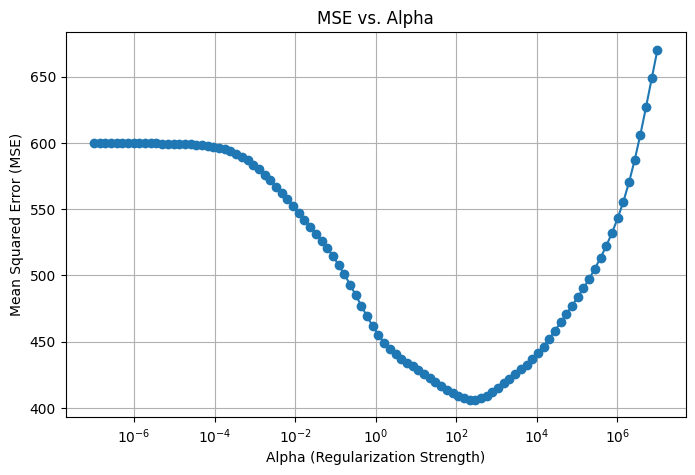

In [120]:
# Plot of MSE  vs. alphas
plt.figure(figsize=(8, 5))
plt.plot(alphas, mse_list, marker='o')

plt.xscale('log')
plt.xlabel('Alpha (Regularization Strength)')
plt.ylabel('Mean Squared Error (MSE)')
plt.title('MSE vs. Alpha')
plt.grid(True)
plt.show()

Which value of $\alpha$ gives the minimum MSE? Is it better than the unregularized model? Why should the curve reach ~700 on the left?

YOUR ANSWER HERE

Now implement the same model using sklearn. Use the `linear_model.Ridge` object to do so.


In [121]:
from sklearn.linear_model import Ridge

In [38]:
def ridge_regression_sklearn(X_test, X_train, y_train, alpha):
    '''Computes OLS weights for regularized linear regression with regularization strength alpha using the sklearn
       library on the training set and returns weights and testset predictions.

       Inputs:
         X_test: (n_observations, 81), numpy array with predictor values of the test set
         X_train: (n_observations, 81), numpy array with predictor values of the training set
         y_train: (n_observations,) numpy array with true target values for the training set
         alpha: scalar, regularization strength

       Outputs:
         weights: The weight vector for the regerssion model including the offset
         y_pred: The predictions on the TEST set

       Note:
         The sklearn library automatically takes care of adding a column for the offset.
    '''

    # ---------------- INSERT CODE ----------------------
    # Create a linear regression model using sklearn
    model = Ridge(alpha=alpha)
    # Fit the model to the training data
    model.fit(X_train, y_train)

    # Obtain the predictions on the test set
    y_pred = model.predict(X_test)

    # Get the weights (including the offset term)
    weights = np.hstack((np.array([model.intercept_]), model.coef_))
    



    # ---------------- END CODE -------------------------

    return weights, y_pred

This time, only plot how the performance changes as a function of $\alpha$. 

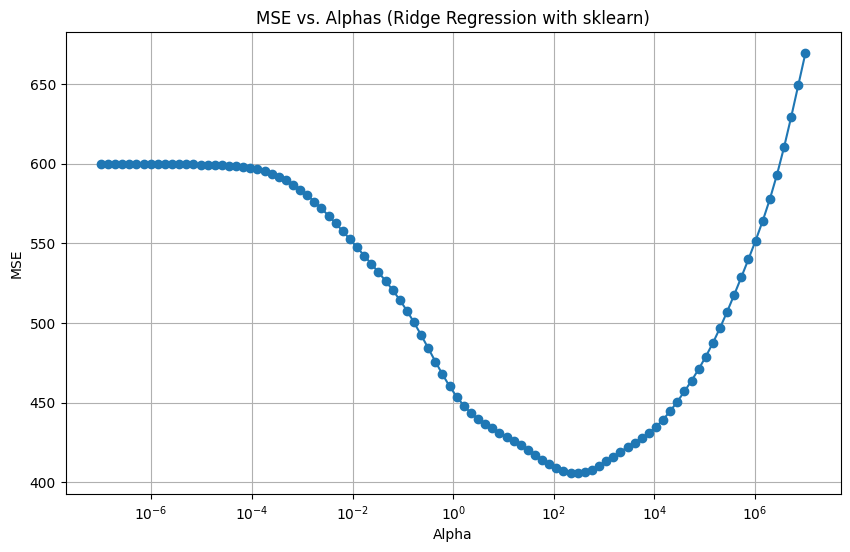

In [40]:
# Plot of MSE  vs. alphas
# Initialize lists to store the MSE and weights
mse_list = []

# Loop through alphas, fit the model, and compute the MSE
for alpha in alphas:
    weights, y_pred = ridge_regression_sklearn(X_test, X_train, y_train, alpha)
    mse = mean_squared_error(y_test, y_pred)
    mse_list.append(mse)

# Plot MSE vs. alphas
plt.figure(figsize=(10,6))
plt.semilogx(alphas, mse_list, marker='o')
plt.xlabel('Alpha')
plt.ylabel('MSE')
plt.title('MSE vs. Alphas (Ridge Regression with sklearn)')
plt.grid()
plt.show()

Note: Don't worry if the curve is not exactly identical to the one you got above. The loss function we wrote down in the lecture  has $\alpha$ defined a bit differently compared to sklearn. However, qualitatively it should look the same.

## Task 5: Cross-validation

Until now, we always estimated the error on the test set directly. However, we typically do not want to tune hyperparameters of our inference algorithms like $\alpha$ on the test set, as this may lead to overfitting. Therefore, we tune them on the training set using cross-validation. As discussed in the lecture, the training data is here split in `n_folds`-ways, where each of the folds serves as a held-out dataset in turn and the model is always trained on the remaining data. Implement a function that performs cross-validation for the ridge regression parameter $\alpha$. You can reuse functions written above.

In [122]:
def ridgeCV(X, y, n_folds, alphas):
    '''Runs a n_fold-crossvalidation over the ridge regression parameter alpha.
       The function should train the linear regression model for each fold on all values of alpha.

      Inputs:
        X: (n_obs, n_features) numpy array - predictor
        y: (n_obs,) numpy array - target
        n_folds: integer - number of CV folds
        alphas: (n_parameters,) - regularization strength parameters to CV over

      Outputs:
        cv_results_mse: (n_folds, len(alphas)) numpy array, MSE for each cross-validation fold

      Note:
        Fix the seed for reproducibility.
    '''

    cv_results_mse = np.zeros((n_folds, len(alphas)))
    np.random.seed(seed=2)

    # Shuffle the indices of the dataset
    indices = np.random.permutation(X.shape[0])

    # Split the indices into n_folds equal parts
    fold_indices = np.array_split(indices, n_folds)

    # Loop through the folds
    for i, valid_idx in enumerate(fold_indices):
        # Create the validation set and the training set
        X_valid = X[valid_idx]
        y_valid = y[valid_idx]

        train_idx = np.concatenate([fold_indices[j] for j in range(n_folds) if j != i])
        X_train = X[train_idx]
        y_train = y[train_idx]

        # Loop through alphas
        for j, alpha in enumerate(alphas):
            # Fit the ridge regression model on the training set
            weights, y_pred = ridge_regression(X_valid, X_train, y_train, alpha)

            # Compute the MSE on the validation set
            mse = mean_squared_error(y_valid, y_pred)

            # Store the result
            cv_results_mse[i, j] = mse

    # ---------------- END CODE -------------------------

    return cv_results_mse

Now we run 10-fold cross-validation using the training data of a range of $\alpha$s.

In [123]:
alphas = np.logspace(-7, 7, 100)
mse_cv = ridgeCV(X_train, y_train, n_folds=10, alphas=alphas)

We plot the MSE trace for each fold separately:

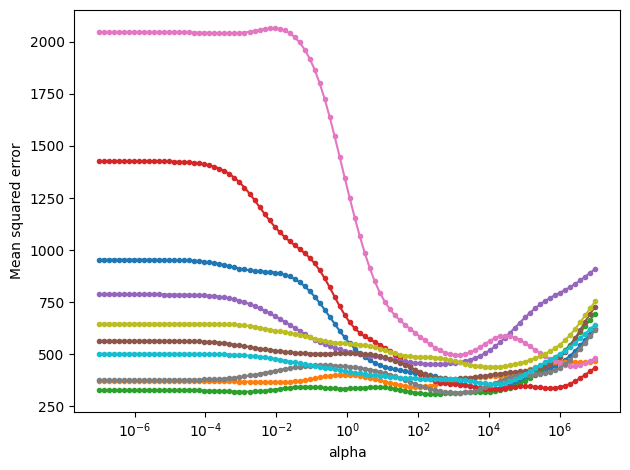

In [124]:
plt.plot(alphas, mse_cv.T, '.-')
plt.xscale('log')
plt.xlabel('alpha')
plt.ylabel('Mean squared error')
plt.tight_layout()

We also plot the average across folds:

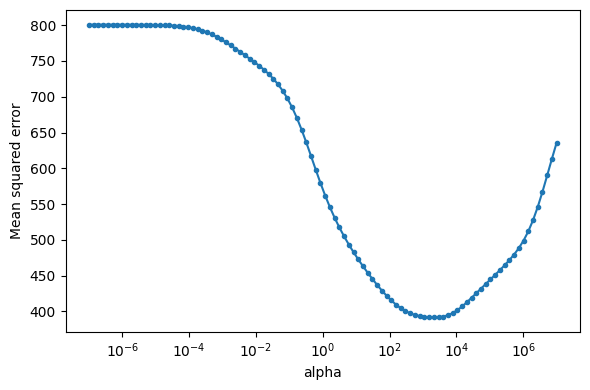

In [125]:
plt.figure(figsize=(6, 4))
plt.plot(alphas, np.mean(mse_cv, axis=0), '.-')
plt.xscale('log')
plt.xlabel('alpha')
plt.ylabel('Mean squared error')
plt.tight_layout()

In [127]:
mse_mean = np.mean(mse_cv,axis = 0)
index = 0
for i in range(len(mse_mean)):
    if mse_mean[i] < mse_mean[index]:
        index = i
print("Optimal alpha: ",alphas[index])
print("Min MSE: ",mse_mean[index])

Optimal alpha:  2104.904144512022
Min MSE:  391.6197971907985


What is the optimal $\alpha$? Is it similar to the one found on the test set? Do the cross-validation MSE and the test-set MSE match well or differ strongly?

YOUR ANSWER HERE

We will now run cross-validation on the full training data. This will take a moment, depending on the speed of your computer. Afterwards, we will again plot the mean CV curves for the full data set (blue) and the small data set (orange).

In [51]:
alphas = np.logspace(-7, 7, 100)
mse_cv_full = ridgeCV(X_train_full, y_train_full, n_folds=10, alphas=alphas)

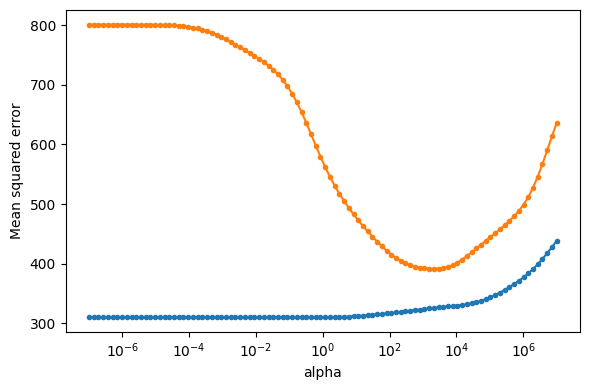

In [52]:
plt.figure(figsize=(6, 4))
plt.plot(alphas, np.mean(mse_cv_full, axis=0), '.-')
plt.plot(alphas, np.mean(mse_cv, axis=0), '.-')
plt.xscale('log')
plt.xlabel('alpha')
plt.ylabel('Mean squared error')
plt.tight_layout()

We zoom in on the blue curve to the very left:

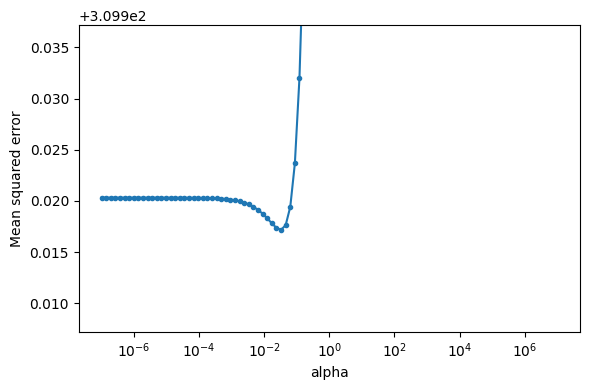

In [53]:
plt.figure(figsize=(6, 4))
plt.plot(alphas, np.mean(mse_cv_full, axis=0), '.-')
plt.xscale('log')
minValue = np.min(np.mean(mse_cv_full, axis=0))
plt.ylim([minValue-.01, minValue+.02])
plt.xlabel('alpha')
plt.ylabel('Mean squared error')
plt.tight_layout()

Why does the CV curve on the full data set look so different? What is the optimal value of $\alpha$ and why is it so much smaller than on the small training set?

YOUR ANSWER HERE